# Running multiple models with BMI in one "Framework"
## Conceptual Functional Equivalent (CFE) Model
## Penman function for an estimate of evaporation
## Bucket model representing some downstream reservoir

In [2]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './cfe')
import bmi_cfe
sys.path.insert(0, './penman')
import bmi_penman
sys.path.insert(0, './bucket')
import bmi_bucket

### Create an instance of the model with a specific configuration that corresponds to a particular catchmenmt.

In [3]:
cfe_instance = bmi_cfe.BMI_CFE()
penman_instance = bmi_penman.BMI_PENMAN()
bucket_instance = bmi_bucket.BMI_BUCKET()

In [4]:
cfe_instance.initialize(cfg_file='./cfe/cat_58_config_cfe.json')
penman_instance.initialize(cfg_file='./penman/cat_58_config_penman.json')
bucket_instance.initialize(cfg_file='./bucket/cat_58_config_bucket.json')

In [9]:
penman_instance.get_output_var_names()

['land_surface_water__evaporation_volume_flux']

In [8]:
cfe_instance.get_output_var_names()

['land_surface_water__runoff_depth',
 'land_surface_water__runoff_volume_flux',
 'DIRECT_RUNOFF',
 'GIUH_RUNOFF',
 'NASH_LATERAL_RUNOFF',
 'DEEP_GW_TO_CHANNEL_FLUX']

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [6]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

### We will want to visualize the model output

In [5]:
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

penman_outputs=penman_instance.get_output_var_names()
penman_output_lists = {output:[] for output in penman_outputs}

bucket_outputs=bucket_instance.get_output_var_names()
bucket_output_lists = {output:[] for output in bucket_outputs}

### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
cfe_instance.get_current_time()

Timestamp('1970-01-01 00:00:00')

In [7]:
df_forcing.head()

,time,APCP_surface,DLWRF_surface,DSWRF_surface,PRES_surface,SPFH_2maboveground,TMP_2maboveground,UGRD_10maboveground,VGRD_10maboveground,precip_rate
0,2015-12-01 00:00:00,0.0,361.200012,0.0,100530.0,0.0105,287.500000,-2.6,0.0,0.0
1,2015-12-01 01:00:00,0.0,361.200012,0.0,100610.0,0.0098,287.300018,-2.7,-0.3,0.0
2,2015-12-01 02:00:00,0.0,361.200012,0.0,100600.0,0.0091,286.600006,-2.8,-0.6,0.0
3,2015-12-01 03:00:00,0.0,357.600006,0.0,100570.0,0.0087,285.500000,-2.9,-0.9,0.0
4,2015-12-01 04:00:00,0.0,357.600006,0.0,100590.0,0.0084,284.300018,-2.6,-0.3,0.0


In [8]:
for i in range(0, df_forcing['APCP_surface'].shape[0]*3600, 100):
    
    if (i % 3600 == 0):
        
        hour_of_simulation = i/3600
        
        precip = df_forcing.loc[hour_of_simulation, 'APCP_surface']
        TMP_2maboveground = df_forcing.loc[hour_of_simulation, 'TMP_2maboveground']
        
        # Estimate the evaporation
        penman_instance.set_value('land_surface_air__temperature', TMP_2maboveground)
        penman_instance.update()
        e = penman_instance.get_value("land_surface_water__evaporation_volume_flux")
        # Run the hydrology model
        cfe_instance.set_value('water_potential_evaporation_flux', e/1000)    
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)    
        cfe_instance.update()
        
    # Watershed flows into some reservoir
    into_bucket = cfe_instance.get_value("land_surface_water__runoff_depth")
    bucket_instance.set_value('water__input_volume_flux', into_bucket)
    bucket_instance.set_value('water_potential_evaporation_flux', e/1000)
    bucket_instance.update()#_until(framework_time)
    
    
    if (i % 3600 == 0):
        for output in cfe_outputs:

            cfe_output_lists[output].append(cfe_instance.get_value(output))

        for output in penman_outputs:

            penman_output_lists[output].append(penman_instance.get_value(output))

        for output in bucket_outputs:

            bucket_output_lists[output].append(bucket_instance.get_value(output))
    
    # if i > 36000:
    #     break

In [10]:
cfe_output_lists

{'land_surface_water__runoff_depth': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'land_surface_water__runoff_volume_flux': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'DIRECT_RUNOFF': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'GIUH_RUNOFF': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'NASH_LATERAL_RUNOFF': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'DEEP_GW_TO_CHANNEL_FLUX': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [9]:
bucket_output_lists

{'bucket__overflow': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'bucket__outlet': [0.2505525892414532, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'bucket__water_surface_elevation': [1.9972587444820862,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [9]:
for i, precip in enumerate(df_forcing['APCP_surface']):
    
    framework_time = (1+i)*3600 # Seconds since starting simulation
    
    # print("\nBefore models are updated")
    # print(cfe_instance.get_current_time())
    # print(penman_instance.get_current_time())
    # print(bucket_instance.get_current_time())
    
    # Estimate the evaporation
    penman_instance.set_value('land_surface_air__temperature', df_forcing.loc[i,'TMP_2maboveground'])
    
    penman_instance.update()
    
    e = penman_instance.get_value("land_surface_water__evaporation_volume_flux")
    
    # Run the hydrology model
    cfe_instance.set_value('water_potential_evaporation_flux', e/1000)    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)    
    cfe_instance.update()
    
    # Watershed flows into some reservoir
    into_bucket = cfe_instance.get_value("land_surface_water__runoff_depth")
    bucket_instance.set_value('water__input_volume_flux', into_bucket)
    bucket_instance.set_value('water_potential_evaporation_flux', e/1000)
    bucket_instance.update_until(framework_time)
    
    for output in cfe_outputs:
    
        cfe_output_lists[output].append(cfe_instance.get_value(output))

        
    for output in penman_outputs:
    
        penman_output_lists[output].append(penman_instance.get_value(output))

    for output in bucket_outputs:
    
        bucket_output_lists[output].append(bucket_instance.get_value(output))
        
        
#     print("\nAfter models are updated")
#     print(cfe_instance.get_current_time())
#     print(penman_instance.get_current_time())
#     print(bucket_instance.get_current_time())
        
#     if i > 3:
#         break


### The finalize function should perform all tasks that take place after exiting the model’s time loop. This typically includes deallocating memory, closing files and printing reports.

In [9]:
cfe_instance.finalize(print_mass_balance=True)
bucket_instance.finalize(print_mass_balance=True)
penman_instance.finalize()


GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 259.2000
   volume output: 160.3678
    final volume:  -1.3882
        residual: 9.5592e+01

SCHAAKE MASS BALANCE
  surface runoff: 165.5922
    infiltration:   9.4389
schaake residual: 8.4169e+01

GIUH MASS BALANCE
  vol. into giuh: 165.5922
   vol. out giuh: 160.3678
 vol. end giuh q:   5.2243
   giuh residual: 7.9936e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   9.4389
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:  -1.3982
vol. soil resid.: 1.1423e+01

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00

MASS BALANCE
  initial:   2.0000
  input: 2504.4915
  f

### Here we are just plotting the fluxes.

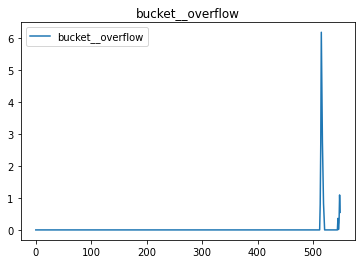

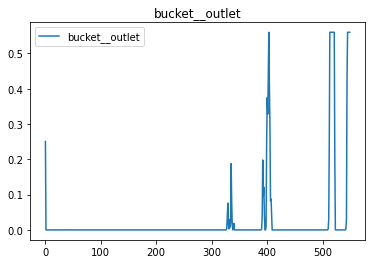

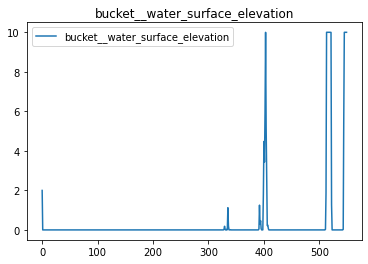

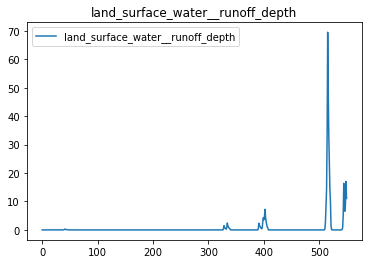

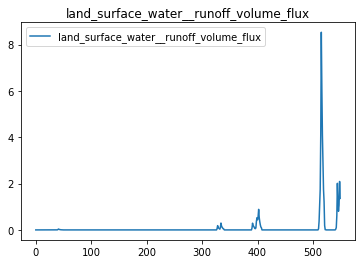

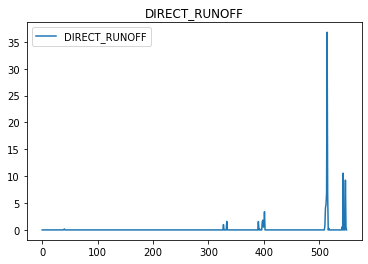

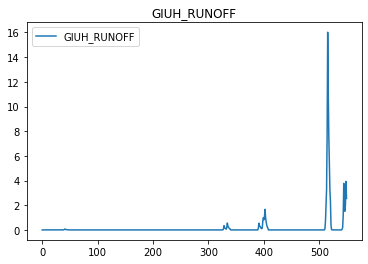

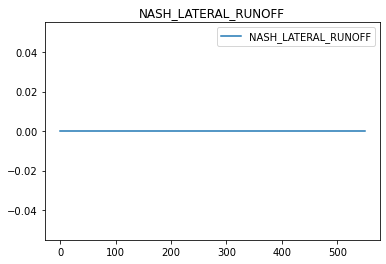

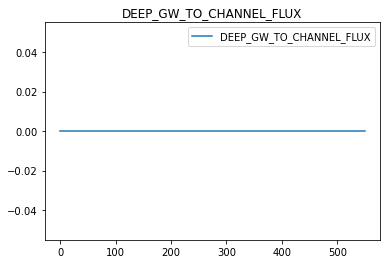

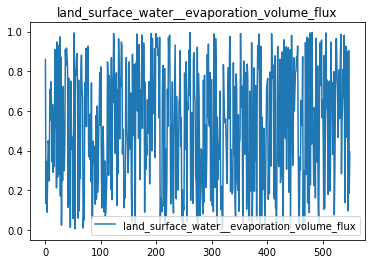

In [12]:
istart_plot=0
iend_plot=550
x = list(range(istart_plot, iend_plot))
for output in bucket_outputs:
    plt.plot(x, bucket_output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    
    plt.close()
for output in cfe_outputs:
    plt.plot(x, cfe_output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()
for output in penman_outputs:
    plt.plot(x, penman_output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()

### Here we are just going to run the unit test that compares with the origional author code. Kind of the same thing done above, but there is a function in the BMI code that does it all at once.